In [3]:
!pip install Faker

import pandas as pd
import numpy as np
from faker import Faker
import random
import sqlite3
from datetime import datetime, timedelta

# Initialize Faker for synthetic data generation
fake = Faker()

# --- Configuration for Data Generation ---
NUM_CUSTOMERS = 10000  # Number of customers
NUM_ACCOUNTS_PER_CUSTOMER_MAX = 2 # Most customers have 1 account, some have 2
NUM_TRANSACTIONS_PER_ACCOUNT_MAX = 100 # Max transactions per account over a period
NUM_PAYMENTS_PER_ACCOUNT_MAX = 10 # Max payments per account over a period
NUM_INTERACTIONS_PER_ACCOUNT_MAX = 5 # Max customer service interactions

START_DATE = datetime(2023, 1, 1)
END_DATE = datetime(2024, 12, 31) # Data up to end of 2024

# --- 1. Generate Customers Data ---
print("Generating Customers data...")
customers_data = []
customer_ids = range(10000, 10000 + NUM_CUSTOMERS) # Starting customer_id from 10000

for i in customer_ids:
    first_name = fake.first_name()
    last_name = fake.last_name()
    email = f"{first_name.lower()}.{last_name.lower()}{i}@example.com"
    # FIX: Changed date_of_between to date_between
    date_of_birth = fake.date_between(start_date="-50y", end_date="-18y").strftime('%Y-%m-%d')
    credit_score = random.randint(300, 850) # FICO score range
    income = round(random.uniform(30000, 200000), 2)
    region = random.choice(['Northeast', 'Midwest', 'South', 'West'])
    customers_data.append([i, first_name, last_name, email, date_of_birth, credit_score, income, region])

df_customers = pd.DataFrame(customers_data, columns=[
    'customer_id', 'first_name', 'last_name', 'email', 'date_of_birth', 'credit_score', 'income', 'region'
])
print(f"Generated {len(df_customers)} Customers records.")

# --- 2. Generate Accounts Data ---
print("Generating Accounts data...")
accounts_data = []
account_id_counter = 20000 # Starting account_id from 20000

for customer_id in df_customers['customer_id']:
    num_accounts = random.choices([1, 2], weights=[0.8, 0.2], k=1)[0] # 80% 1 account, 20% 2 accounts
    for _ in range(num_accounts):
        account_id_counter += 1
        account_type = random.choice(['Visa Platinum', 'Mastercard Rewards', 'Discover IT', 'Amex Gold', 'Visa Secured', 'Mastercard Classic', 'Visa Signature'])
        credit_limit = round(random.uniform(2000, 30000), 2)
        # FIX: Changed date_of_between to date_between
        opened_date = fake.date_between(start_date=START_DATE, end_date=datetime(2024, 1, 1)).strftime('%Y-%m-%d') # Accounts generally opened before current data

        # Simulate some churned accounts
        closed_date = None
        account_status = 'Active'
        if random.random() < 0.05: # 5% of accounts are churned (closed)
            # Ensure closed_date is after opened_date and within the data range
            min_closed_date = datetime.strptime(opened_date, '%Y-%m-%d') + timedelta(days=90)
            # FIX: Changed date_of_between to date_between
            closed_date_obj = fake.date_between(start_date=min_closed_date, end_date=END_DATE)
            closed_date = closed_date_obj.strftime('%Y-%m-%d')
            account_status = 'Closed'

        current_balance = round(random.uniform(0, credit_limit * 0.8), 2) # Balance is max 80% of limit

        accounts_data.append([account_id_counter, customer_id, account_type, credit_limit, current_balance, opened_date, closed_date, account_status])

df_accounts = pd.DataFrame(accounts_data, columns=[
    'account_id', 'customer_id', 'account_type', 'credit_limit', 'current_balance', 'opened_date', 'closed_date', 'account_status'
])
print(f"Generated {len(df_accounts)} Accounts records.")

# --- 3. Generate Transactions Data ---
print("Generating Transactions data...")
transactions_data = []
transaction_id_counter = 30000 # Starting transaction_id from 30000

# Filter active accounts and recently closed accounts for transaction generation
active_and_recently_closed_accounts = df_accounts[
    (df_accounts['account_status'] == 'Active') |
    ((df_accounts['account_status'] == 'Closed') & (pd.to_datetime(df_accounts['closed_date']) >= START_DATE))
].copy() # Use .copy() to avoid SettingWithCopyWarning

# Convert date columns to datetime objects for easier comparison
active_and_recently_closed_accounts['opened_date_dt'] = pd.to_datetime(active_and_recently_closed_accounts['opened_date'])
active_and_recently_closed_accounts['closed_date_dt'] = pd.to_datetime(active_and_recently_closed_accounts['closed_date'])

for _, account in active_and_recently_closed_accounts.iterrows():
    account_id = account['account_id']
    opened_date = account['opened_date_dt']
    closed_date = account['closed_date_dt'] if pd.notna(account['closed_date_dt']) else END_DATE + timedelta(days=1) # If active, allow transactions up to end date

    # Ensure transaction dates are within the account's active period
    transaction_end_date = min(END_DATE, closed_date - timedelta(days=1)) # Transactions should stop before close date

    # Only generate transactions if there's a valid period for them
    # Ensure start_date is before end_date
    if transaction_end_date >= opened_date: # Changed > to >= for single-day validity
        num_transactions = random.randint(1, NUM_TRANSACTIONS_PER_ACCOUNT_MAX)
        for _ in range(num_transactions):
            transaction_id_counter += 1
            # Handle potential case where opened_date is very close to transaction_end_date
            if opened_date >= transaction_end_date:
                # If the window is too small, just use the end date
                txn_date = transaction_end_date
            else:
                # FIX: Changed date_of_between to date_between
                txn_date = fake.date_between(start_date=opened_date, end_date=transaction_end_date)

            amount = round(random.uniform(5.00, 1000.00), 2)
            transaction_type = random.choice(['Purchase', 'Refund', 'Cash Advance'])
            merchant_category = random.choice(['Groceries', 'Retail', 'Dining', 'Travel', 'Utilities', 'Online Services', 'Gas', 'Healthcare', 'Entertainment'])
            transactions_data.append([transaction_id_counter, account_id, txn_date.strftime('%Y-%m-%d'), amount, transaction_type, merchant_category])

df_transactions = pd.DataFrame(transactions_data, columns=[
    'transaction_id', 'account_id', 'transaction_date', 'amount', 'transaction_type', 'merchant_category'
])
print(f"Generated {len(df_transactions)} Transactions records.")

# --- 4. Generate Payments Data ---
print("Generating Payments data...")
payments_data = []
payment_id_counter = 40000 # Starting payment_id from 40000

for _, account in active_and_recently_closed_accounts.iterrows():
    account_id = account['account_id']
    opened_date = account['opened_date_dt']
    closed_date = account['closed_date_dt'] if pd.notna(account['closed_date_dt']) else END_DATE + timedelta(days=1)

    payment_end_date = min(END_DATE, closed_date - timedelta(days=1))

    if payment_end_date >= opened_date:
        num_payments = random.randint(1, NUM_PAYMENTS_PER_ACCOUNT_MAX)
        for _ in range(num_payments):
            payment_id_counter += 1
            if opened_date >= payment_end_date:
                pymt_date = payment_end_date
            else:
                # FIX: Changed date_of_between to date_between
                pymt_date = fake.date_between(start_date=opened_date, end_date=payment_end_date)

            amount = round(random.uniform(10.00, 5000.00), 2)
            payment_type = random.choice(['Online', 'Auto-Pay', 'Check', 'Phone'])
            payments_data.append([payment_id_counter, account_id, pymt_date.strftime('%Y-%m-%d'), amount, payment_type])

df_payments = pd.DataFrame(payments_data, columns=[
    'payment_id', 'account_id', 'payment_date', 'amount', 'payment_type'
])
print(f"Generated {len(df_payments)} Payments records.")

# --- 5. Generate CustomerServiceInteractions Data ---
print("Generating CustomerServiceInteractions data...")
interactions_data = []
interaction_id_counter = 50000 # Starting interaction_id from 50000

for _, account in active_and_recently_closed_accounts.iterrows():
    account_id = account['account_id']
    opened_date = account['opened_date_dt']
    closed_date = account['closed_date_dt'] if pd.notna(account['closed_date_dt']) else END_DATE + timedelta(days=1)

    interaction_end_date = min(END_DATE, closed_date - timedelta(days=1))

    if interaction_end_date >= opened_date:
        num_interactions = random.randint(0, NUM_INTERACTIONS_PER_ACCOUNT_MAX) # Some accounts might have no interactions
        for _ in range(num_interactions):
            interaction_id_counter += 1
            if opened_date >= interaction_end_date:
                int_date = interaction_end_date
            else:
                # FIX: Changed date_of_between to date_between
                int_date = fake.date_between(start_date=opened_date, end_date=interaction_end_date)

            interaction_type = random.choice(['Call', 'Chat', 'Email'])
            resolution_status = random.choice(['Resolved', 'Unresolved', 'Pending'])
            issue_type = random.choice(['Billing Dispute', 'Fraud Inquiry', 'Account Closure Request', 'General Inquiry', 'Credit Limit Increase', 'Rewards Inquiry'])
            interactions_data.append([interaction_id_counter, account_id, int_date.strftime('%Y-%m-%d'), interaction_type, resolution_status, issue_type])

df_interactions = pd.DataFrame(interactions_data, columns=[
    'interaction_id', 'account_id', 'interaction_date', 'interaction_type', 'resolution_status', 'issue_type'
])
print(f"Generated {len(df_interactions)} CustomerServiceInteractions records.")

# --- Create SQLite Database in Colab and Load DataFrames ---
print("\nCreating SQLite database and loading data...")
conn = sqlite3.connect(':memory:') # Use an in-memory SQLite database

# Function to load DataFrame into SQLite
def load_df_to_sqlite(df, table_name, connection):
    df.to_sql(table_name, connection, if_exists='replace', index=False)
    print(f"Loaded {len(df)} records into '{table_name}' table.")

load_df_to_sqlite(df_customers, 'Customers', conn)
load_df_to_sqlite(df_accounts, 'Accounts', conn)
load_df_to_sqlite(df_transactions, 'Transactions', conn)
load_df_to_sqlite(df_payments, 'Payments', conn)
load_df_to_sqlite(df_interactions, 'CustomerServiceInteractions', conn)

print("\nDatabase setup complete. You can now run SQL queries using 'conn'.")

# --- Example of running a query to verify ---
print("\nExample Query: Count of Customers by Region")
query = """
SELECT region, COUNT(customer_id) AS num_customers
FROM Customers
GROUP BY region;
"""
df_query_result = pd.read_sql_query(query, conn)
print(df_query_result)

print("\nExample Query: Accounts Status Distribution")
query_accounts = """
SELECT account_status, COUNT(account_id) AS num_accounts
FROM Accounts
GROUP BY account_status;
"""
df_accounts_status = pd.read_sql_query(query_accounts, conn)
print(df_accounts_status)

print("\nExample Query: Last transaction date for each account")
query_last_transaction = """
SELECT
    account_id,
    MAX(transaction_date) AS last_transaction_date
FROM
    Transactions
GROUP BY
    account_id
ORDER BY
    account_id
LIMIT 5;
"""
df_last_transaction = pd.read_sql_query(query_last_transaction, conn)
print(df_last_transaction)

Generating Customers data...
Generated 10000 Customers records.
Generating Accounts data...
Generated 11976 Accounts records.
Generating Transactions data...
Generated 605379 Transactions records.
Generating Payments data...
Generated 65866 Payments records.
Generating CustomerServiceInteractions data...
Generated 29984 CustomerServiceInteractions records.

Creating SQLite database and loading data...
Loaded 10000 records into 'Customers' table.
Loaded 11976 records into 'Accounts' table.
Loaded 605379 records into 'Transactions' table.
Loaded 65866 records into 'Payments' table.
Loaded 29984 records into 'CustomerServiceInteractions' table.

Database setup complete. You can now run SQL queries using 'conn'.

Example Query: Count of Customers by Region
      region  num_customers
0    Midwest           2529
1  Northeast           2472
2      South           2530
3       West           2469

Example Query: Accounts Status Distribution
  account_status  num_accounts
0         Active     

In [4]:
import pandas as pd
import sqlite3

# Assuming 'conn' is your sqlite3 connection object established from the previous data generation step

# List of table names to inspect
table_names = ['Customers', 'Accounts', 'Transactions', 'Payments', 'CustomerServiceInteractions']

print("--- Inspecting Created Tables (First 10 Records Each) ---\n")

for table_name in table_names:
    print(f"--- Table: {table_name} ---")
    query = f"SELECT * FROM {table_name} LIMIT 10;"
    try:
        df_table = pd.read_sql_query(query, conn)
        if not df_table.empty:
            print("Columns:", df_table.columns.tolist())
            print(df_table)
        else:
            print(f"Table '{table_name}' is empty or has fewer than 10 records.")
    except pd.io.sql.DatabaseError as e:
        print(f"Error querying table {table_name}: {e}")
    print("\n" + "="*50 + "\n") # Separator for readability

print("--- Inspection Complete ---")

--- Inspecting Created Tables (First 10 Records Each) ---

--- Table: Customers ---
Columns: ['customer_id', 'first_name', 'last_name', 'email', 'date_of_birth', 'credit_score', 'income', 'region']
   customer_id first_name  last_name                               email  \
0        10000       Adam   Gonzalez      adam.gonzalez10000@example.com   
1        10001    Randall       Boyd       randall.boyd10001@example.com   
2        10002     Joshua       Long        joshua.long10002@example.com   
3        10003     Monica     Gordon      monica.gordon10003@example.com   
4        10004      Julie    Holland      julie.holland10004@example.com   
5        10005      Grant      Miles        grant.miles10005@example.com   
6        10006     Amanda      Gomez       amanda.gomez10006@example.com   
7        10007    Dominic  Dougherty  dominic.dougherty10007@example.com   
8        10008    Jessica     Larsen     jessica.larsen10008@example.com   
9        10009       Carl    Mcgrath      

In [6]:
import pandas as pd
import sqlite3
from datetime import datetime, timedelta

# --- Assumed: The data generation code (from previous steps) has already been run
# --- and 'conn' (the sqlite3 connection object) is available.

# --- Define the core observation date for our analysis ---
OBSERVATION_DATE = '2024-06-30'
LAST_3_MONTHS_START = '2024-03-31' # 3 months prior to OBSERVATION_DATE

print(f"--- Starting Feature Engineering with Observation Date: {OBSERVATION_DATE} ---")

# --- Sub-Step 3.1: Create a Base Table for Accounts and their Churn Status ---
# Objective: Identify each unique account and determine if it has churned
#            based on our definition and the observation date.
# Definition of Churn: An account is considered 'churned' if its 'account_status'
#                      is 'Closed' AND its 'closed_date' is on or before the OBSERVATION_DATE.
print("\n--- Sub-Step 3.1: Generating Base Accounts with Churn Status ---")
query_base_churn = f"""
SELECT
    a.account_id,
    a.customer_id,
    a.account_type,
    a.credit_limit,
    a.current_balance,
    a.opened_date,
    -- Our target variable: 1 if churned, 0 if not
    CASE
        WHEN a.account_status = 'Closed' AND a.closed_date <= '{OBSERVATION_DATE}' THEN 1
        ELSE 0
    END AS is_churned,
    a.account_status AS current_account_status -- Original status for reference
FROM
    Accounts AS a
WHERE
    -- Only include accounts that were opened on or before our observation date.
    -- We cannot predict churn for accounts that didn't exist yet.
    a.opened_date <= '{OBSERVATION_DATE}'
ORDER BY
    a.account_id;
"""

# Execute the query and load results into a Pandas DataFrame
df_base_churn = pd.read_sql_query(query_base_churn, conn)

# Display some initial insights from the base DataFrame
print(f"Total accounts considered up to {OBSERVATION_DATE}: {len(df_base_churn)}")
print("First 5 rows of df_base_churn:")
print(df_base_churn.head())
print("\nChurn Status Distribution:")
print(df_base_churn['is_churned'].value_counts())
print(f"Calculated Churn Rate: {df_base_churn['is_churned'].mean() * 100:.2f}%")

# --- Sub-Step 3.2: Aggregate Transactional Features ---
# Objective: Summarize transaction data for each account.
# We'll calculate total spending, number of transactions, average transaction amount,
# and unique merchant categories. We'll do this for both overall history
# and a recent 3-month window to capture recent behavioral changes.
print("\n--- Sub-Step 3.2: Aggregating Transactional Features ---")
query_transactions_features = f"""
SELECT
    t.account_id,
    -- Overall Transactional Features (from account opened date up to OBSERVATION_DATE)
    COUNT(t.transaction_id) AS total_transactions_overall,
    SUM(t.amount) AS total_spending_overall,
    AVG(t.amount) AS avg_transaction_amount_overall,
    MAX(t.transaction_date) AS last_transaction_date_overall,
    MIN(t.transaction_date) AS first_transaction_date_overall,

    -- Transactional Features for the last 3 months (from LAST_3_MONTHS_START to OBSERVATION_DATE)
    -- This window captures recent activity trends which are often strong indicators.
    SUM(CASE WHEN t.transaction_date >= '{LAST_3_MONTHS_START}' AND t.transaction_date <= '{OBSERVATION_DATE}' THEN t.amount ELSE 0 END) AS total_spending_last_3_months,
    COUNT(CASE WHEN t.transaction_date >= '{LAST_3_MONTHS_START}' AND t.transaction_date <= '{OBSERVATION_DATE}' THEN t.transaction_id ELSE NULL END) AS total_transactions_last_3_months,
    AVG(CASE WHEN t.transaction_date >= '{LAST_3_MONTHS_START}' AND t.transaction_date <= '{OBSERVATION_DATE}' THEN t.amount ELSE NULL END) AS avg_transaction_amount_last_3_months,
    COUNT(DISTINCT CASE WHEN t.transaction_date >= '{LAST_3_MONTHS_START}' AND t.transaction_date <= '{OBSERVATION_DATE}' THEN t.merchant_category ELSE NULL END) AS unique_merchant_categories_last_3_months

FROM
    Transactions AS t
WHERE
    t.transaction_date <= '{OBSERVATION_DATE}' -- Only consider transactions that occurred up to our observation date
GROUP BY
    t.account_id
ORDER BY
    t.account_id;
"""

# Execute the query and load results into a Pandas DataFrame
df_transactions_features = pd.read_sql_query(query_transactions_features, conn)

print("First 5 rows of aggregated transactional features:")
print(df_transactions_features.head())
print(f"Total accounts with transaction data: {len(df_transactions_features)}")

# --- Merge these newly created transactional features into our base DataFrame ---
# We use a LEFT JOIN to ensure that ALL accounts from 'df_base_churn' are kept.
# If an account had no transactions up to the observation date, it will still be included
# in the final DataFrame, but its transaction-related features will be NaN (Not a Number).
df_churn_features = pd.merge(df_base_churn, df_transactions_features, on='account_id', how='left')

# --- Handle Missing Values (NaNs) created by the LEFT JOIN ---
# Accounts that had no transactions will have NaN for their transaction features.
# It's important to replace these NaNs with a meaningful value, often 0 for counts/sums,
# as 'no transactions' means 0 spending, 0 transactions.
# For averages, NaN might be kept or imputed more sophisticatedly later, but for now, 0
# for counts and sums is a safe start.
print("\n--- Filling missing values in new transactional features ---")
df_churn_features['total_transactions_overall'] = df_churn_features['total_transactions_overall'].fillna(0)
df_churn_features['total_spending_overall'] = df_churn_features['total_spending_overall'].fillna(0)
# 'avg_transaction_amount_overall' will remain NaN if total_transactions_overall is 0. This is okay.

df_churn_features['total_spending_last_3_months'] = df_churn_features['total_spending_last_3_months'].fillna(0)
df_churn_features['total_transactions_last_3_months'] = df_churn_features['total_transactions_last_3_months'].fillna(0)
# 'avg_transaction_amount_last_3_months' will remain NaN if total_transactions_last_3_months is 0. This is okay.

df_churn_features['unique_merchant_categories_last_3_months'] = df_churn_features['unique_merchant_categories_last_3_months'].fillna(0)


print("\n--- Merged DataFrame with Transactional Features (first 5 rows) ---")
print(df_churn_features.head())
print("\n--- Merged DataFrame Info (to check new columns and remaining NaNs) ---")
df_churn_features.info()

--- Starting Feature Engineering with Observation Date: 2024-06-30 ---

--- Sub-Step 3.1: Generating Base Accounts with Churn Status ---
Total accounts considered up to 2024-06-30: 11976
First 5 rows of df_base_churn:
   account_id  customer_id        account_type  credit_limit  current_balance  \
0       20001        10000       Visa Platinum       3704.93           212.28   
1       20002        10001        Visa Secured      28511.05         14323.40   
2       20003        10001         Discover IT      23773.32         15994.60   
3       20004        10002        Visa Secured      17434.13          5892.43   
4       20005        10002  Mastercard Rewards       4052.95          2648.56   

  opened_date  is_churned current_account_status  
0  2023-04-18           0                 Active  
1  2023-07-18           0                 Active  
2  2023-12-15           0                 Active  
3  2023-12-15           0                 Active  
4  2023-02-18           0               

In [7]:
# Assuming 'conn' is your sqlite3 connection object and
# 'df_churn_features' is the DataFrame from the previous step (Sub-Step 3.2)

# Define the observation date and the start of the 3-month window (re-affirming for clarity)
OBSERVATION_DATE = '2024-06-30'
LAST_3_MONTHS_START = '2024-03-31' # 3 months prior to OBSERVATION_DATE

print("\n--- Sub-Step 3.3: Aggregating Payment Features ---")
query_payments_features = f"""
SELECT
    p.account_id,
    COUNT(p.payment_id) AS total_payments_overall,
    SUM(p.amount) AS total_amount_paid_overall,
    AVG(p.amount) AS avg_payment_amount_overall,
    MAX(p.payment_date) AS last_payment_date_overall,

    SUM(CASE WHEN p.payment_date >= '{LAST_3_MONTHS_START}' AND p.payment_date <= '{OBSERVATION_DATE}' THEN p.amount ELSE 0 END) AS total_amount_paid_last_3_months,
    COUNT(CASE WHEN p.payment_date >= '{LAST_3_MONTHS_START}' AND p.payment_date <= '{OBSERVATION_DATE}' THEN p.payment_id ELSE NULL END) AS total_payments_last_3_months,
    AVG(CASE WHEN p.payment_date >= '{LAST_3_MONTHS_START}' AND p.payment_date <= '{OBSERVATION_DATE}' THEN p.amount ELSE NULL END) AS avg_payment_amount_last_3_months,
    COUNT(DISTINCT CASE WHEN p.payment_date >= '{LAST_3_MONTHS_START}' AND p.payment_date <= '{OBSERVATION_DATE}' THEN p.payment_type ELSE NULL END) AS unique_payment_types_last_3_months

FROM
    Payments AS p
WHERE
    p.payment_date <= '{OBSERVATION_DATE}'
GROUP BY
    p.account_id
ORDER BY
    p.account_id;
"""

# Execute the query and load results into a Pandas DataFrame
df_payments_features = pd.read_sql_query(query_payments_features, conn)

print("First 5 rows of aggregated payment features:")
print(df_payments_features.head())
print(f"Total accounts with payment data: {len(df_payments_features)}")

# --- Merge these newly created payment features into our main DataFrame (`df_churn_features`) ---
# Again, use LEFT JOIN to preserve all accounts from the main DataFrame.
# Accounts with no payments will have NaN for these new features.
df_churn_features = pd.merge(df_churn_features, df_payments_features, on='account_id', how='left')

# --- Handle Missing Values (NaNs) for new payment features ---
# Replace NaNs with 0 for counts and sums, indicating no payments.
print("\n--- Filling missing values in new payment features ---")
df_churn_features['total_payments_overall'] = df_churn_features['total_payments_overall'].fillna(0)
df_churn_features['total_amount_paid_overall'] = df_churn_features['total_amount_paid_overall'].fillna(0)
# avg_payment_amount_overall will remain NaN if total_payments_overall is 0.

df_churn_features['total_amount_paid_last_3_months'] = df_churn_features['total_amount_paid_last_3_months'].fillna(0)
df_churn_features['total_payments_last_3_months'] = df_churn_features['total_payments_last_3_months'].fillna(0)
# avg_payment_amount_last_3_months will remain NaN if total_payments_last_3_months is 0.

df_churn_features['unique_payment_types_last_3_months'] = df_churn_features['unique_payment_types_last_3_months'].fillna(0)


print("\n--- Merged DataFrame with Payment Features (first 5 rows) ---")
print(df_churn_features.head())
print("\n--- Merged DataFrame Info (to check new columns and remaining NaNs) ---")
df_churn_features.info()


--- Sub-Step 3.3: Aggregating Payment Features ---
First 5 rows of aggregated payment features:
   account_id  total_payments_overall  total_amount_paid_overall  \
0       20001                       3                    8653.30   
1       20002                       1                    4163.28   
2       20003                       6                   11756.93   
3       20004                       2                    5443.63   
4       20005                       5                    8555.24   

   avg_payment_amount_overall last_payment_date_overall  \
0                 2884.433333                2024-03-08   
1                 4163.280000                2023-08-05   
2                 1959.488333                2024-06-07   
3                 2721.815000                2024-04-25   
4                 1711.048000                2024-05-31   

   total_amount_paid_last_3_months  total_payments_last_3_months  \
0                             0.00                             0   
1  

In [8]:
# Assuming 'conn' is your sqlite3 connection object and
# 'df_churn_features' is the DataFrame from the previous step (Sub-Step 3.3)

# Define the observation date and the start of the 3-month window (re-affirming for clarity)
OBSERVATION_DATE = '2024-06-30'
LAST_3_MONTHS_START = '2024-03-31'

print("\n--- Sub-Step 3.4: Aggregating Customer Service Interaction Features ---")
query_interactions_features = f"""
SELECT
    csi.account_id,
    COUNT(csi.interaction_id) AS total_interactions_overall,
    SUM(CASE WHEN csi.resolution_status = 'Unresolved' THEN 1 ELSE 0 END) AS unresolved_interactions_overall,
    MAX(csi.interaction_date) AS last_interaction_date_overall,

    SUM(CASE WHEN csi.interaction_date >= '{LAST_3_MONTHS_START}' AND csi.interaction_date <= '{OBSERVATION_DATE}' THEN 1 ELSE 0 END) AS total_interactions_last_3_months,
    SUM(CASE WHEN csi.interaction_date >= '{LAST_3_MONTHS_START}' AND csi.interaction_date <= '{OBSERVATION_DATE}' AND csi.resolution_status = 'Unresolved' THEN 1 ELSE 0 END) AS unresolved_interactions_last_3_months,

    SUM(CASE WHEN csi.interaction_date >= '{LAST_3_MONTHS_START}' AND csi.interaction_date <= '{OBSERVATION_DATE}' AND csi.issue_type = 'Account Closure Request' THEN 1 ELSE 0 END) AS account_closure_requests_last_3_months,
    SUM(CASE WHEN csi.interaction_date >= '{LAST_3_MONTHS_START}' AND csi.interaction_date <= '{OBSERVATION_DATE}' AND csi.issue_type = 'Billing Dispute' THEN 1 ELSE 0 END) AS billing_disputes_last_3_months

FROM
    CustomerServiceInteractions AS csi
WHERE
    csi.interaction_date <= '{OBSERVATION_DATE}'
GROUP BY
    csi.account_id
ORDER BY
    csi.account_id;
"""

# Execute the query and load results into a Pandas DataFrame
df_interactions_features = pd.read_sql_query(query_interactions_features, conn)

print("First 5 rows of aggregated interaction features:")
print(df_interactions_features.head())
print(f"Total accounts with interaction data: {len(df_interactions_features)}")

# --- Merge these newly created interaction features into our main DataFrame (`df_churn_features`) ---
# Use LEFT JOIN to ensure all accounts from df_churn_features are kept.
# Accounts with no interactions will have NaN for these new features.
df_churn_features = pd.merge(df_churn_features, df_interactions_features, on='account_id', how='left')

# --- Handle Missing Values (NaNs) for new interaction features ---
# Replace NaNs with 0 for counts and sums, indicating no interactions or specific issue types.
print("\n--- Filling missing values in new interaction features ---")
df_churn_features['total_interactions_overall'] = df_churn_features['total_interactions_overall'].fillna(0)
df_churn_features['unresolved_interactions_overall'] = df_churn_features['unresolved_interactions_overall'].fillna(0)
# last_interaction_date_overall might remain NaN or be filled with an 'epoch' date if truly no interaction.
# For now, we'll let it be NaN and decide on imputation strategy later.

df_churn_features['total_interactions_last_3_months'] = df_churn_features['total_interactions_last_3_months'].fillna(0)
df_churn_features['unresolved_interactions_last_3_months'] = df_churn_features['unresolved_interactions_last_3_months'].fillna(0)
df_churn_features['account_closure_requests_last_3_months'] = df_churn_features['account_closure_requests_last_3_months'].fillna(0)
df_churn_features['billing_disputes_last_3_months'] = df_churn_features['billing_disputes_last_3_months'].fillna(0)


print("\n--- Merged DataFrame with Interaction Features (first 5 rows) ---")
print(df_churn_features.head())
print("\n--- Merged DataFrame Info (to check new columns and remaining NaNs) ---")
df_churn_features.info()


--- Sub-Step 3.4: Aggregating Customer Service Interaction Features ---
First 5 rows of aggregated interaction features:
   account_id  total_interactions_overall  unresolved_interactions_overall  \
0       20001                           1                                0   
1       20004                           1                                0   
2       20005                           3                                0   
3       20006                           1                                0   
4       20007                           1                                0   

  last_interaction_date_overall  total_interactions_last_3_months  \
0                    2023-08-17                                 0   
1                    2024-06-22                                 1   
2                    2023-12-01                                 0   
3                    2023-11-15                                 0   
4                    2024-06-12                                 

In [10]:
import pandas as pd
import sqlite3
from datetime import datetime, timedelta

# --- Assumed: The initial data generation script (with !pip install Faker and fake.date_between fixes)
# --- has already been run successfully and 'conn' is available, along with df_customers.

# --- Define the core observation date for our analysis ---
OBSERVATION_DATE = '2024-06-30'
LAST_3_MONTHS_START = '2024-03-31' # 3 months prior to OBSERVATION_DATE

print(f"--- Starting Comprehensive Feature Engineering with Observation Date: {OBSERVATION_DATE} ---")

# --- Sub-Step 3.1: Create a Base Table for Accounts and their Churn Status ---
# Objective: Identify each unique account and determine if it has churned
#            based on our definition and the observation date.
print("\n--- Sub-Step 3.1: Generating Base Accounts with Churn Status ---")
query_base_churn = f"""
SELECT
    a.account_id,
    a.customer_id,
    a.account_type,
    a.credit_limit,
    a.current_balance,
    a.opened_date,
    a.closed_date, -- Keep closed_date for now, needed for tenure/active period
    -- Our target variable: 1 if churned, 0 if not
    CASE
        WHEN a.account_status = 'Closed' AND a.closed_date <= '{OBSERVATION_DATE}' THEN 1
        ELSE 0
    END AS is_churned,
    a.account_status AS current_account_status -- Original status for reference
FROM
    Accounts AS a
WHERE
    a.opened_date <= '{OBSERVATION_DATE}'
ORDER BY
    a.account_id;
"""

# Execute the query and load results into a Pandas DataFrame
df_base_churn = pd.read_sql_query(query_base_churn, conn)

print(f"Total accounts considered up to {OBSERVATION_DATE}: {len(df_base_churn)}")
print("First 5 rows of df_base_churn:")
print(df_base_churn.head())

# --- NEW: Merge Customer Information (date_of_birth, income, credit_score, region) ---
# Objective: Add customer-specific demographic and credit information to our base DataFrame.
# This ensures 'date_of_birth' is available for time-based calculations.
print("\n--- Merging Customer Information into Base DataFrame ---")
df_churn_features = pd.merge(df_base_churn, df_customers[['customer_id', 'date_of_birth', 'credit_score', 'income', 'region']], on='customer_id', how='left')

print("First 5 rows of df_churn_features after adding Customer info:")
print(df_churn_features.head())
print("\nChurn Status Distribution:")
print(df_churn_features['is_churned'].value_counts())
print(f"Calculated Churn Rate: {df_churn_features['is_churned'].mean() * 100:.2f}%")


# --- Sub-Step 3.2: Aggregate Transactional Features ---
print("\n--- Sub-Step 3.2: Aggregating Transactional Features ---")
query_transactions_features = f"""
SELECT
    t.account_id,
    COUNT(t.transaction_id) AS total_transactions_overall,
    SUM(t.amount) AS total_spending_overall,
    AVG(t.amount) AS avg_transaction_amount_overall,
    MAX(t.transaction_date) AS last_transaction_date_overall,
    MIN(t.transaction_date) AS first_transaction_date_overall,

    SUM(CASE WHEN t.transaction_date >= '{LAST_3_MONTHS_START}' AND t.transaction_date <= '{OBSERVATION_DATE}' THEN t.amount ELSE 0 END) AS total_spending_last_3_months,
    COUNT(CASE WHEN t.transaction_date >= '{LAST_3_MONTHS_START}' AND t.transaction_date <= '{OBSERVATION_DATE}' THEN t.transaction_id ELSE NULL END) AS total_transactions_last_3_months,
    AVG(CASE WHEN t.transaction_date >= '{LAST_3_MONTHS_START}' AND t.transaction_date <= '{OBSERVATION_DATE}' THEN t.amount ELSE NULL END) AS avg_transaction_amount_last_3_months,
    COUNT(DISTINCT CASE WHEN t.transaction_date >= '{LAST_3_MONTHS_START}' AND t.transaction_date <= '{OBSERVATION_DATE}' THEN t.merchant_category ELSE NULL END) AS unique_merchant_categories_last_3_months

FROM
    Transactions AS t
WHERE
    t.transaction_date <= '{OBSERVATION_DATE}'
GROUP BY
    t.account_id
ORDER BY
    t.account_id;
"""

df_transactions_features = pd.read_sql_query(query_transactions_features, conn)
print("First 5 rows of aggregated transactional features:")
print(df_transactions_features.head())

# Merge these features
df_churn_features = pd.merge(df_churn_features, df_transactions_features, on='account_id', how='left')

# Fill NaN values for new transaction features
print("\n--- Filling missing values in new transactional features ---")
df_churn_features['total_transactions_overall'] = df_churn_features['total_transactions_overall'].fillna(0)
df_churn_features['total_spending_overall'] = df_churn_features['total_spending_overall'].fillna(0)
df_churn_features['total_spending_last_3_months'] = df_churn_features['total_spending_last_3_months'].fillna(0)
df_churn_features['total_transactions_last_3_months'] = df_churn_features['total_transactions_last_3_months'].fillna(0)
df_churn_features['unique_merchant_categories_last_3_months'] = df_churn_features['unique_merchant_categories_last_3_months'].fillna(0)


# --- Sub-Step 3.3: Aggregate Payment Features ---
print("\n--- Sub-Step 3.3: Aggregating Payment Features ---")
query_payments_features = f"""
SELECT
    p.account_id,
    COUNT(p.payment_id) AS total_payments_overall,
    SUM(p.amount) AS total_amount_paid_overall,
    AVG(p.amount) AS avg_payment_amount_overall,
    MAX(p.payment_date) AS last_payment_date_overall,

    SUM(CASE WHEN p.payment_date >= '{LAST_3_MONTHS_START}' AND p.payment_date <= '{OBSERVATION_DATE}' THEN p.amount ELSE 0 END) AS total_amount_paid_last_3_months,
    COUNT(CASE WHEN p.payment_date >= '{LAST_3_MONTHS_START}' AND p.payment_date <= '{OBSERVATION_DATE}' THEN p.payment_id ELSE NULL END) AS total_payments_last_3_months,
    AVG(CASE WHEN p.payment_date >= '{LAST_3_MONTHS_START}' AND p.payment_date <= '{OBSERVATION_DATE}' THEN p.amount ELSE NULL END) AS avg_payment_amount_last_3_months,
    COUNT(DISTINCT CASE WHEN p.payment_date >= '{LAST_3_MONTHS_START}' AND p.payment_date <= '{OBSERVATION_DATE}' THEN p.payment_type ELSE NULL END) AS unique_payment_types_last_3_months

FROM
    Payments AS p
WHERE
    p.payment_date <= '{OBSERVATION_DATE}'
GROUP BY
    p.account_id
ORDER BY
    p.account_id;
"""

df_payments_features = pd.read_sql_query(query_payments_features, conn)
print("First 5 rows of aggregated payment features:")
print(df_payments_features.head())

# Merge these features
df_churn_features = pd.merge(df_churn_features, df_payments_features, on='account_id', how='left')

# Fill NaN values for new payment features
print("\n--- Filling missing values in new payment features ---")
df_churn_features['total_payments_overall'] = df_churn_features['total_payments_overall'].fillna(0)
df_churn_features['total_amount_paid_overall'] = df_churn_features['total_amount_paid_overall'].fillna(0)
df_churn_features['total_amount_paid_last_3_months'] = df_churn_features['total_amount_paid_last_3_months'].fillna(0)
df_churn_features['total_payments_last_3_months'] = df_churn_features['total_payments_last_3_months'].fillna(0)
df_churn_features['unique_payment_types_last_3_months'] = df_churn_features['unique_payment_types_last_3_months'].fillna(0)


# --- Sub-Step 3.4: Aggregate Customer Service Interaction Features ---
print("\n--- Sub-Step 3.4: Aggregating Customer Service Interaction Features ---")
query_interactions_features = f"""
SELECT
    csi.account_id,
    COUNT(csi.interaction_id) AS total_interactions_overall,
    SUM(CASE WHEN csi.resolution_status = 'Unresolved' THEN 1 ELSE 0 END) AS unresolved_interactions_overall,
    MAX(csi.interaction_date) AS last_interaction_date_overall,

    SUM(CASE WHEN csi.interaction_date >= '{LAST_3_MONTHS_START}' AND csi.interaction_date <= '{OBSERVATION_DATE}' THEN 1 ELSE 0 END) AS total_interactions_last_3_months,
    SUM(CASE WHEN csi.interaction_date >= '{LAST_3_MONTHS_START}' AND csi.interaction_date <= '{OBSERVATION_DATE}' AND csi.resolution_status = 'Unresolved' THEN 1 ELSE 0 END) AS unresolved_interactions_last_3_months,

    SUM(CASE WHEN csi.interaction_date >= '{LAST_3_MONTHS_START}' AND csi.interaction_date <= '{OBSERVATION_DATE}' AND csi.issue_type = 'Account Closure Request' THEN 1 ELSE 0 END) AS account_closure_requests_last_3_months,
    SUM(CASE WHEN csi.interaction_date >= '{LAST_3_MONTHS_START}' AND csi.interaction_date <= '{OBSERVATION_DATE}' AND csi.issue_type = 'Billing Dispute' THEN 1 ELSE 0 END) AS billing_disputes_last_3_months

FROM
    CustomerServiceInteractions AS csi
WHERE
    csi.interaction_date <= '{OBSERVATION_DATE}'
GROUP BY
    csi.account_id
ORDER BY
    csi.account_id;
"""

df_interactions_features = pd.read_sql_query(query_interactions_features, conn)
print("First 5 rows of aggregated interaction features:")
print(df_interactions_features.head())

# Merge these features
df_churn_features = pd.merge(df_churn_features, df_interactions_features, on='account_id', how='left')

# Fill NaN values for new interaction features
print("\n--- Filling missing values in new interaction features ---")
df_churn_features['total_interactions_overall'] = df_churn_features['total_interactions_overall'].fillna(0)
df_churn_features['unresolved_interactions_overall'] = df_churn_features['unresolved_interactions_overall'].fillna(0)
df_churn_features['total_interactions_last_3_months'] = df_churn_features['total_interactions_last_3_months'].fillna(0)
df_churn_features['unresolved_interactions_last_3_months'] = df_churn_features['unresolved_interactions_last_3_months'].fillna(0)
df_churn_features['account_closure_requests_last_3_months'] = df_churn_features['account_closure_requests_last_3_months'].fillna(0)
df_churn_features['billing_disputes_last_3_months'] = df_churn_features['billing_disputes_last_3_months'].fillna(0)


# --- Sub-Step 3.5: Create Time-Based Features (Derived from Dates) ---
print(f"\n--- Sub-Step 3.5: Creating Time-Based Features (Derived from Dates) ---")

# Convert relevant date columns to datetime objects
OBSERVATION_DATE_DT = datetime.strptime(OBSERVATION_DATE, '%Y-%m-%d')
VERY_OLD_DATE = datetime(1900, 1, 1) # For filling NaNs to signify long inactivity

# Ensure these columns exist before attempting to convert
if 'opened_date' in df_churn_features.columns:
    df_churn_features['opened_date_dt'] = pd.to_datetime(df_churn_features['opened_date'], errors='coerce')
if 'last_transaction_date_overall' in df_churn_features.columns:
    df_churn_features['last_transaction_date_overall_dt'] = pd.to_datetime(df_churn_features['last_transaction_date_overall'], errors='coerce')
if 'last_payment_date_overall' in df_churn_features.columns:
    df_churn_features['last_payment_date_overall_dt'] = pd.to_datetime(df_churn_features['last_payment_date_overall'], errors='coerce')
if 'last_interaction_date_overall' in df_churn_features.columns:
    df_churn_features['last_interaction_date_overall_dt'] = pd.to_datetime(df_churn_features['last_interaction_date_overall'], errors='coerce')
# This is the crucial column that was missing:
if 'date_of_birth' in df_churn_features.columns:
    df_churn_features['date_of_birth_dt'] = pd.to_datetime(df_churn_features['date_of_birth'], errors='coerce')
else:
    print("WARNING: 'date_of_birth' column not found in df_churn_features. Customer age will not be calculated.")
    df_churn_features['date_of_birth_dt'] = pd.NaT # Set to Not a Time if missing


# Feature 1: Account Tenure (how long account has been open)
print("Calculating account tenure...")
df_churn_features['account_tenure_days'] = (OBSERVATION_DATE_DT - df_churn_features['opened_date_dt']).dt.days
df_churn_features['account_tenure_days'] = df_churn_features['account_tenure_days'].apply(lambda x: max(0, x) if pd.notna(x) else x) # Handle NaNs from coercion

# Feature 2: Days Since Last Activity
print("Calculating days since last transaction, payment, and interaction...")
df_churn_features['days_since_last_transaction'] = (
    OBSERVATION_DATE_DT - df_churn_features['last_transaction_date_overall_dt'].fillna(VERY_OLD_DATE)
).dt.days

df_churn_features['days_since_last_payment'] = (
    OBSERVATION_DATE_DT - df_churn_features['last_payment_date_overall_dt'].fillna(VERY_OLD_DATE)
).dt.days

df_churn_features['days_since_last_interaction'] = (
    OBSERVATION_DATE_DT - df_churn_features['last_interaction_date_overall_dt'].fillna(VERY_OLD_DATE)
).dt.days


# Feature 3: Customer Age at Observation Date
print("Calculating customer age...")
if 'date_of_birth_dt' in df_churn_features.columns and not df_churn_features['date_of_birth_dt'].isnull().all():
    df_churn_features['customer_age_at_obs'] = (OBSERVATION_DATE_DT - df_churn_features['date_of_birth_dt']).dt.days / 365.25
    df_churn_features['customer_age_at_obs'].fillna(df_churn_features['customer_age_at_obs'].median(), inplace=True)
    df_churn_features['customer_age_at_obs'] = df_churn_features['customer_age_at_obs'].round().astype('Int64') # Use 'Int64' for nullable integer
else:
    df_churn_features['customer_age_at_obs'] = pd.NA # Or a sensible default if DOB is truly unavailable

# --- Drop the intermediate datetime columns and original date strings ---
columns_to_drop = [
    'opened_date', 'date_of_birth', 'closed_date', # original strings
    'last_transaction_date_overall', 'last_payment_date_overall', 'last_interaction_date_overall', # original strings from aggregates
    'opened_date_dt', 'last_transaction_date_overall_dt',
    'last_payment_date_overall_dt', 'last_interaction_date_overall_dt',
    'date_of_birth_dt'
]
# Only drop columns if they exist in the DataFrame
df_churn_features.drop(columns=[col for col in columns_to_drop if col in df_churn_features.columns], inplace=True, errors='ignore')


print("\n--- Final Merged DataFrame with All Engineered Features (first 5 rows) ---")
print(df_churn_features.head())
print("\n--- Final Merged DataFrame Info (to check all columns and data types) ---")
df_churn_features.info()
print(f"\nTotal columns in final feature set: {len(df_churn_features.columns)}")

--- Starting Comprehensive Feature Engineering with Observation Date: 2024-06-30 ---

--- Sub-Step 3.1: Generating Base Accounts with Churn Status ---
Total accounts considered up to 2024-06-30: 11976
First 5 rows of df_base_churn:
   account_id  customer_id        account_type  credit_limit  current_balance  \
0       20001        10000       Visa Platinum       3704.93           212.28   
1       20002        10001        Visa Secured      28511.05         14323.40   
2       20003        10001         Discover IT      23773.32         15994.60   
3       20004        10002        Visa Secured      17434.13          5892.43   
4       20005        10002  Mastercard Rewards       4052.95          2648.56   

  opened_date closed_date  is_churned current_account_status  
0  2023-04-18        None           0                 Active  
1  2023-07-18        None           0                 Active  
2  2023-12-15        None           0                 Active  
3  2023-12-15        None    

/tmp/ipython-input-10-3827696313.py:234: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_churn_features['customer_age_at_obs'].fillna(df_churn_features['customer_age_at_obs'].median(), inplace=True)


In [11]:
import pandas as pd
import numpy as np # Often useful for numerical operations

# --- Assumed: df_churn_features is already available and populated from previous steps.

print("\n--- Sub-Step 4.1: Handling Remaining Missing Values ---")

# --- 1. Inspect Missing Values ---
# It's good practice to first see how many NaNs are in each column.
print("\nMissing values before imputation:")
print(df_churn_features.isnull().sum()[df_churn_features.isnull().sum() > 0])

# Columns that likely have NaNs due to no activity and where 0 is a meaningful fill:
# These are the average columns where the denominator was 0 (no transactions/payments).
cols_to_fill_with_zero = [
    'avg_transaction_amount_overall',
    'avg_transaction_amount_last_3_months',
    'avg_payment_amount_overall',
    'avg_payment_amount_last_3_months'
]

# --- 2. Impute (Fill) Missing Values ---
# For these specific average columns, replace NaN with 0.
print(f"\nFilling NaN values in {cols_to_fill_with_zero} with 0...")
for col in cols_to_fill_with_zero:
    if col in df_churn_features.columns: # Check if column exists
        df_churn_features[col] = df_churn_features[col].fillna(0)

# We also filled NaNs in `account_tenure_days` and `customer_age_at_obs`
# with appropriate values in Sub-Step 3.5. Let's re-verify.
# If `customer_age_at_obs` could still have `pd.NA` (nullable integer), convert it
# to float for consistent numerical processing if needed, then fill with median.
if 'customer_age_at_obs' in df_churn_features.columns:
    # Ensure it's a numeric type first, then fill
    df_churn_features['customer_age_at_obs'] = pd.to_numeric(df_churn_features['customer_age_at_obs'], errors='coerce')
    if df_churn_features['customer_age_at_obs'].isnull().any():
        median_age = df_churn_features['customer_age_at_obs'].median()
        df_churn_features['customer_age_at_obs'].fillna(median_age, inplace=True)
        print(f"Filled missing 'customer_age_at_obs' with median: {median_age:.0f}")

# Re-check for any remaining missing values after our targeted imputation
print("\nMissing values after imputation:")
remaining_nans = df_churn_features.isnull().sum()[df_churn_features.isnull().sum() > 0]
if remaining_nans.empty:
    print("No missing values remaining in the DataFrame.")
else:
    print(remaining_nans)
    print("\nWARNING: Some missing values still exist. Review these columns.")


print("\n--- DataFrame Info after Missing Value Handling ---")
df_churn_features.info()
print(f"\nShape of DataFrame: {df_churn_features.shape}")


--- Sub-Step 4.1: Handling Remaining Missing Values ---

Missing values before imputation:
avg_transaction_amount_overall            63
first_transaction_date_overall            63
avg_transaction_amount_last_3_months     817
avg_payment_amount_overall               617
avg_payment_amount_last_3_months        4961
dtype: int64

Filling NaN values in ['avg_transaction_amount_overall', 'avg_transaction_amount_last_3_months', 'avg_payment_amount_overall', 'avg_payment_amount_last_3_months'] with 0...

Missing values after imputation:
first_transaction_date_overall    63
dtype: int64


--- DataFrame Info after Missing Value Handling ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11976 entries, 0 to 11975
Data columns (total 36 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   account_id                                11976 non-null  int64  
 1   customer_id                    

In [13]:
import pandas as pd

# --- Assumed: df_churn_features is already available and populated from previous steps.

print("\n--- Sub-Step 4.2: Encoding Categorical Features ---")

# --- 1. Identify Categorical Columns ---
# We look for columns with 'object' (string) or 'category' dtype.
# IMPORTANT: We need to be careful with columns that are 'object' but contain dates or IDs.
categorical_cols = []
for col in df_churn_features.columns:
    if df_churn_features[col].dtype == 'object':
        # Heuristic to check if it's truly categorical (e.g., fewer than 50 unique values
        # or clearly not an identifier/date string). Adjust threshold if needed.
        if df_churn_features[col].nunique() < 50 and not 'date' in col and not 'id' in col:
            categorical_cols.append(col)
        # Explicitly include 'Region' and 'account_type' if they are objects
        elif col in ['region', 'account_type', 'payment_type']: # Add other known categorical columns if not caught
            categorical_cols.append(col)


# Exclude identifier and redundant columns that might still be 'object' type
# 'customer_id' is an identifier.
# 'current_account_status' is redundant with 'is_churned' (our target).
# 'first_transaction_date_overall' is an original date string, handled by derived numerical features.
# Any other raw date strings that might have slipped through should be excluded.
exclude_from_encoding = [
    'customer_id',
    'current_account_status',
    'first_transaction_date_overall', # This is the problematic one from your screenshot
    'last_transaction_date_overall',  # Also a date string, already handled numerically
    'last_payment_date_overall',      # Also a date string, already handled numerically
    'last_interaction_date_overall',  # Also a date string, already handled numerically
    'opened_date', 'closed_date', 'date_of_birth', # Original date strings
    'email', 'first_name', 'last_name' # Identifiers/Names
]

# Filter out the columns we want to exclude from encoding
categorical_cols = [col for col in categorical_cols if col not in exclude_from_encoding]

print(f"\nIdentified categorical columns for encoding: {categorical_cols}")

# --- 2. Perform One-Hot Encoding ---
print("\nApplying One-Hot Encoding...")
# Make a copy to ensure we're working with a fresh state for encoding
df_churn_features_encoded = df_churn_features.copy()

# Drop the original string date columns and other identifiers/redundant columns
# before encoding to prevent them from being accidentally encoded or causing issues.
columns_to_drop_before_encoding = [col for col in exclude_from_encoding if col in df_churn_features_encoded.columns]
df_churn_features_encoded.drop(columns=columns_to_drop_before_encoding, inplace=True, errors='ignore')

# Now apply get_dummies on the filtered categorical columns
df_churn_features_encoded = pd.get_dummies(df_churn_features_encoded, columns=categorical_cols, drop_first=True)

print("\n--- DataFrame Info after Encoding ---")
df_churn_features_encoded.info()
print(f"\nShape of DataFrame after encoding: {df_churn_features_encoded.shape}")

# Display the first few rows to see the new encoded columns, especially 'region_'
print("\nFirst 5 rows of DataFrame with encoded features:")
print(df_churn_features_encoded.head())


--- Sub-Step 4.2: Encoding Categorical Features ---

Identified categorical columns for encoding: ['account_type', 'region']

Applying One-Hot Encoding...

--- DataFrame Info after Encoding ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11976 entries, 0 to 11975
Data columns (total 40 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   account_id                                11976 non-null  int64  
 1   credit_limit                              11976 non-null  float64
 2   current_balance                           11976 non-null  float64
 3   is_churned                                11976 non-null  int64  
 4   credit_score                              11976 non-null  int64  
 5   income                                    11976 non-null  float64
 6   total_transactions_overall                11976 non-null  float64
 7   total_spending_overall                    11976 non-

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np # Used for numerical operations/checks

# --- Assumed: df_churn_features_encoded is already available and populated.

print("\n--- Sub-Step 4.3: Feature Scaling (Numerical Features) ---")

# --- 1. Identify Numerical Columns for Scaling ---
# We need to scale all numerical columns EXCEPT:
# - 'account_id' (identifier)
# - 'customer_id' (identifier)
# - 'is_churned' (our target variable, should not be scaled)
# - Binary (0/1) columns from one-hot encoding (these don't need scaling)

# Get all numerical columns (int, float)
numerical_cols_for_scaling = df_churn_features_encoded.select_dtypes(include=np.number).columns.tolist()

# Exclude identifiers and the target variable
exclude_from_scaling = ['account_id', 'customer_id', 'is_churned']
numerical_cols_for_scaling = [col for col in numerical_cols_for_scaling if col not in exclude_from_scaling]

# Further refine: Exclude one-hot encoded (binary) columns.
# A simple way to approximate this is to check if min and max are 0 and 1.
# This assumes that True/False values from get_dummies have been converted to 1/0.
binary_cols = [col for col in numerical_cols_for_scaling if df_churn_features_encoded[col].nunique() == 2 and
               (df_churn_features_encoded[col].min() == 0 and df_churn_features_encoded[col].max() == 1)]

numerical_cols_for_scaling = [col for col in numerical_cols_for_scaling if col not in binary_cols]


print(f"\nIdentified numerical columns for scaling ({len(numerical_cols_for_scaling)} columns):")
print(numerical_cols_for_scaling)


# --- 2. Initialize and Apply StandardScaler ---
scaler = StandardScaler()

# Create a copy of the DataFrame to store scaled features
df_scaled_features = df_churn_features_encoded.copy()

# Apply scaling only to the identified numerical columns
print("\nApplying StandardScaler to numerical features...")
df_scaled_features[numerical_cols_for_scaling] = scaler.fit_transform(df_scaled_features[numerical_cols_for_scaling])

print("\n--- DataFrame Info after Scaling ---")
df_scaled_features.info()
print(f"\nShape of DataFrame after scaling: {df_scaled_features.shape}")

# Display the first few rows to observe the scaled values
print("\nFirst 5 rows of DataFrame with scaled numerical features (check numerical columns):")
print(df_scaled_features.head())

# Optional: Verify mean and std dev of a scaled column (should be close to 0 and 1)
if len(numerical_cols_for_scaling) > 0:
    sample_col = numerical_cols_for_scaling[0]
    print(f"\nMean of scaled '{sample_col}': {df_scaled_features[sample_col].mean():.4f}")
    print(f"Standard Deviation of scaled '{sample_col}': {df_scaled_features[sample_col].std():.4f}")


--- Sub-Step 4.3: Feature Scaling (Numerical Features) ---

Identified numerical columns for scaling (29 columns):
['credit_limit', 'current_balance', 'credit_score', 'income', 'total_transactions_overall', 'total_spending_overall', 'avg_transaction_amount_overall', 'total_spending_last_3_months', 'total_transactions_last_3_months', 'avg_transaction_amount_last_3_months', 'unique_merchant_categories_last_3_months', 'total_payments_overall', 'total_amount_paid_overall', 'avg_payment_amount_overall', 'total_amount_paid_last_3_months', 'total_payments_last_3_months', 'avg_payment_amount_last_3_months', 'unique_payment_types_last_3_months', 'total_interactions_overall', 'unresolved_interactions_overall', 'total_interactions_last_3_months', 'unresolved_interactions_last_3_months', 'account_closure_requests_last_3_months', 'billing_disputes_last_3_months', 'account_tenure_days', 'days_since_last_transaction', 'days_since_last_payment', 'days_since_last_interaction', 'customer_age_at_obs']



In [15]:
import pandas as pd

# --- Assumed: df_scaled_features is available from the previous Sub-Step 4.3.

print("\n--- Sub-Step 4.4: Preparing X (Features) and Y (Target) ---")

# --- 1. Define the Target Variable (y) ---
# Our target variable is 'is_churned'.
y = df_scaled_features['is_churned']
print(f"Shape of target variable (y): {y.shape}")
print("First 5 values of y:")
print(y.head())

# --- 2. Define the Features (X) ---
# X includes all columns EXCEPT:
# - 'is_churned' (the target)
# - 'account_id' (an identifier, not a feature for the model)
# - 'customer_id' (an identifier, not a feature for the model)

# Create a list of columns to drop from the features (X)
columns_to_drop_for_X = ['is_churned', 'account_id', 'customer_id']

# Create the features DataFrame (X) by dropping these columns
X = df_scaled_features.drop(columns=columns_to_drop_for_X, errors='ignore')

print(f"\nShape of features DataFrame (X): {X.shape}")
print("First 5 rows of X:")
print(X.head())

print("\n--- Final Data Preprocessing Complete! ---")
print("Your features (X) and target (y) are now ready for model training.")


--- Sub-Step 4.4: Preparing X (Features) and Y (Target) ---
Shape of target variable (y): (11976,)
First 5 values of y:
0    0
1    0
2    0
3    0
4    0
Name: is_churned, dtype: int64

Shape of features DataFrame (X): (11976, 38)
First 5 rows of X:
   credit_limit  current_balance  credit_score    income  \
0     -1.518399        -1.173388      1.511251 -0.129287   
1      1.554794         1.498143     -0.503853 -1.354791   
2      0.967844         1.814537     -0.503853 -1.354791   
3      0.182491        -0.098016     -0.794432  1.065920   
4     -1.475283        -0.712149     -0.794432  1.065920   

   total_transactions_overall  total_spending_overall  \
0                    1.235597                1.386206   
1                    1.088771                1.073728   
2                   -1.064684               -0.951286   
3                   -1.211510               -1.060192   
4                    0.795118                0.682798   

   avg_transaction_amount_overall  total_spe

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

# --- Assumed: X and y are already available from Sub-Step 4.4.

print("\n--- Sub-Step 5.1: Splitting Data into Training and Testing Sets ---")

# Define the test set size (e.g., 20% of the data for testing)
test_size = 0.2

# Define a random state for reproducibility
random_state = 42

# Perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    stratify=y # Ensures the proportion of churned customers is similar in train and test sets
)

print(f"\nOriginal dataset shape: X={X.shape}, y={y.shape}")
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")

print("\nProportion of churn in original dataset:")
print(y.value_counts(normalize=True))

print("\nProportion of churn in training set:")
print(y_train.value_counts(normalize=True))

print("\nProportion of churn in testing set:")
print(y_test.value_counts(normalize=True))

print("\n--- Data Split Complete! ---")


--- Sub-Step 5.1: Splitting Data into Training and Testing Sets ---

Original dataset shape: X=(11976, 38), y=(11976,)
Training set shape: X_train=(9580, 38), y_train=(9580,)
Testing set shape: X_test=(2396, 38), y_test=(2396,)

Proportion of churn in original dataset:
is_churned
0    0.970775
1    0.029225
Name: proportion, dtype: float64

Proportion of churn in training set:
is_churned
0    0.970772
1    0.029228
Name: proportion, dtype: float64

Proportion of churn in testing set:
is_churned
0    0.970785
1    0.029215
Name: proportion, dtype: float64

--- Data Split Complete! ---


In [17]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assumed: X_train, X_test, y_train, y_test are available from Sub-Step 5.1.

print("\n--- Sub-Step 5.2: Choosing and Training a Logistic Regression Model ---")

# --- 1. Initialize the Model ---
# We'll use Logistic Regression.
# 'random_state' for reproducibility.
# 'solver' is set to 'liblinear' for smaller datasets and good for L1/L2 regularization.
# 'class_weight='balanced'' is crucial for imbalanced datasets like churn,
# as it gives more importance to the minority class (churned customers).
model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced', max_iter=1000)

print("Logistic Regression model initialized with class_weight='balanced'.")

# --- 2. Train the Model ---
# Train the model using the training data (X_train, y_train).
print("Training the model...")
model.fit(X_train, y_train)

print("\n--- Model Training Complete! ---")
print("The Logistic Regression model has been trained on the training data.")

# We'll move directly to evaluation in the next step using this trained 'model' object.


--- Sub-Step 5.2: Choosing and Training a Logistic Regression Model ---
Logistic Regression model initialized with class_weight='balanced'.
Training the model...

--- Model Training Complete! ---
The Logistic Regression model has been trained on the training data.



--- Sub-Step 5.3: Evaluating Model Performance ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2326
           1       0.24      0.80      0.37        70

    accuracy                           0.92      2396
   macro avg       0.62      0.86      0.67      2396
weighted avg       0.97      0.92      0.94      2396

ROC AUC Score: 0.9433

--- Visualizing Confusion Matrix ---


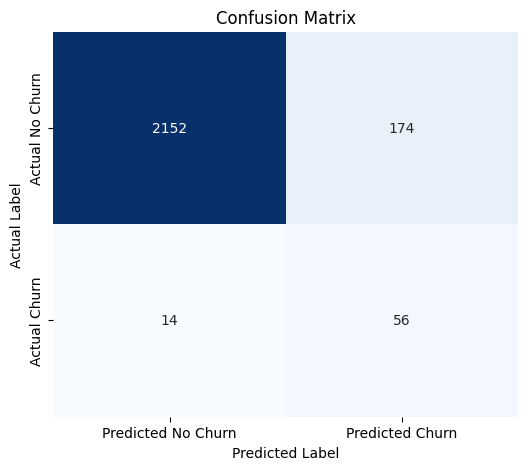


--- Visualizing ROC Curve ---


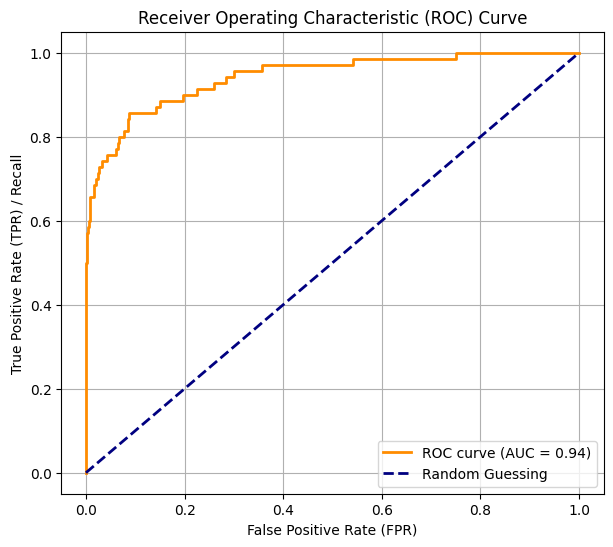


--- Model Evaluation Complete! ---


In [18]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure previously defined model (trained LogisticRegression) is available
# And X_test, y_test are available from Sub-Step 5.1.

print("\n--- Sub-Step 5.3: Evaluating Model Performance ---")

# --- 1. Make Predictions on the Test Set ---
# Predict class labels (0 or 1)
y_pred = model.predict(X_test)

# Predict probabilities of the positive class (churn = 1)
# model.predict_proba returns probabilities for both classes [prob_0, prob_1]
# We want the probability of the positive class (index 1)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# --- 2. Print Classification Report ---
# Provides precision, recall, f1-score for each class.
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

# --- 3. Calculate ROC AUC Score ---
# This is a very important metric for imbalanced classification.
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {auc_score:.4f}")

# --- 4. Visualize Confusion Matrix ---
print("\n--- Visualizing Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# --- 5. Visualize ROC Curve ---
print("\n--- Visualizing ROC Curve ---")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\n--- Model Evaluation Complete! ---")


--- Sub-Step 5.4: Feature Importance Analysis and Interpretation ---

Top 15 Most Important Features (by absolute coefficient value):
                                     Feature  Coefficient  Abs_Coefficient
10  unique_merchant_categories_last_3_months    -1.920847         1.920847
24                       account_tenure_days    -1.301421         1.301421
26                   days_since_last_payment    -1.080728         1.080728
5                     total_spending_overall     1.010292         1.010292
14           total_amount_paid_last_3_months     0.964315         0.964315
18                total_interactions_overall     0.941086         0.941086
34               account_type_Visa Signature    -0.922535         0.922535
15              total_payments_last_3_months    -0.859343         0.859343
4                 total_transactions_overall     0.855774         0.855774
11                    total_payments_overall     0.725040         0.725040
9       avg_transaction_amount_last_3_mo

/tmp/ipython-input-19-1752782273.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=feature_importance_df.head(15), palette='viridis')


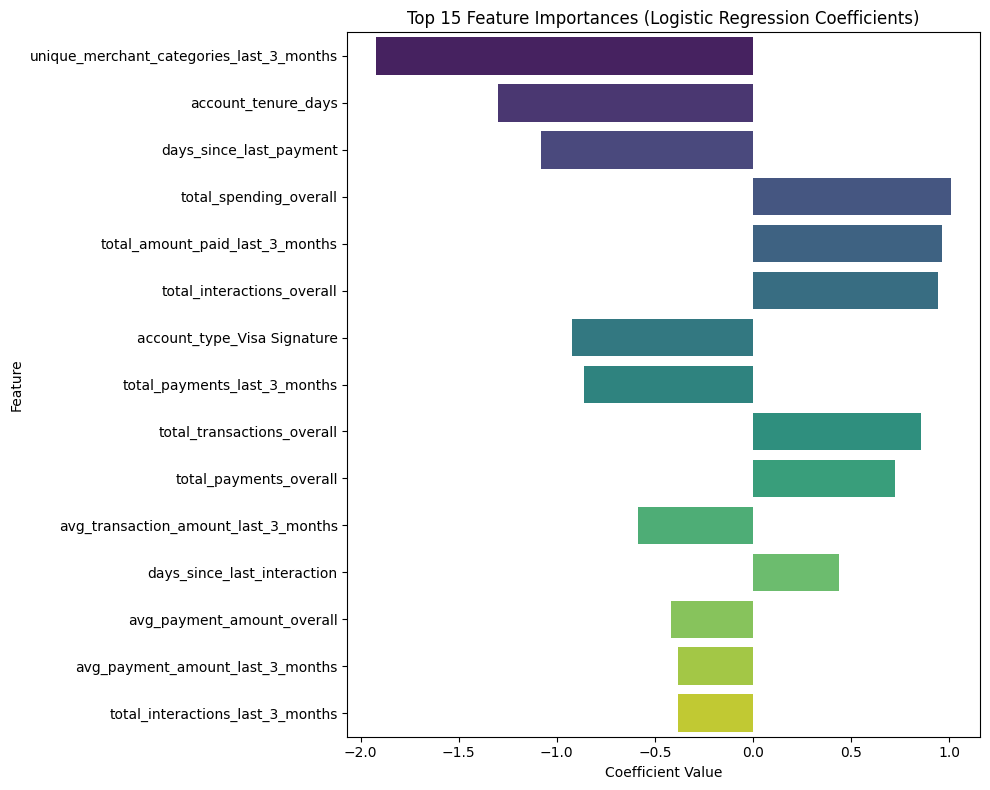


--- Feature Importance Analysis Complete! ---


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assumed: 'model' (trained LogisticRegression) and 'X' (features DataFrame)
# --- are available from previous steps.

print("\n--- Sub-Step 5.4: Feature Importance Analysis and Interpretation ---")

# --- 1. Get Feature Names and Coefficients ---
# The coefficients are stored in model.coef_
# For binary classification, model.coef_ will be a 2D array (1, n_features)
# We take the first (and only) row.
feature_coefficients = model.coef_[0]

# Get the feature names from our X DataFrame
feature_names = X.columns

# Create a DataFrame to easily associate names with coefficients
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': feature_coefficients
})

# --- 2. Sort Features by Absolute Coefficient Value ---
# Sort by the absolute value to see the strongest influences (positive or negative)
feature_importance_df['Abs_Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)

print("\nTop 15 Most Important Features (by absolute coefficient value):")
print(feature_importance_df.head(15))

# --- 3. Visualize Feature Importance ---
print("\n--- Visualizing Top 15 Feature Importances ---")

plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('Top 15 Feature Importances (Logistic Regression Coefficients)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\n--- Feature Importance Analysis Complete! ---")


--- Sub-Step 5.5: Training and Evaluating a Random Forest Classifier ---
Random Forest Classifier initialized with class_weight='balanced'.
Training the Random Forest model...
Out-of-Bag Score: 0.9901

--- Random Forest Model Training Complete! ---

--- Random Forest Classification Report ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2326
           1       0.95      0.59      0.73        70

    accuracy                           0.99      2396
   macro avg       0.97      0.79      0.86      2396
weighted avg       0.99      0.99      0.99      2396

Random Forest ROC AUC Score: 0.9837

--- Visualizing Random Forest Confusion Matrix ---


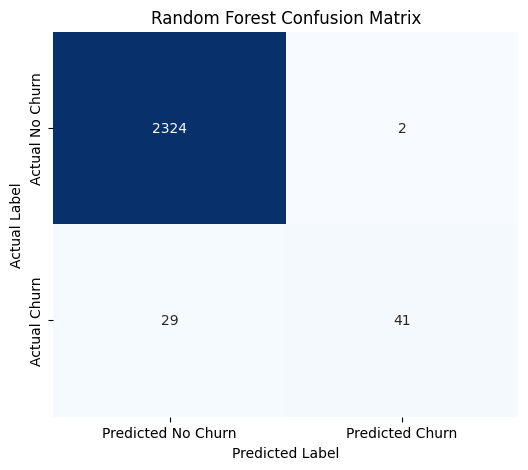


--- Visualizing Random Forest ROC Curve ---


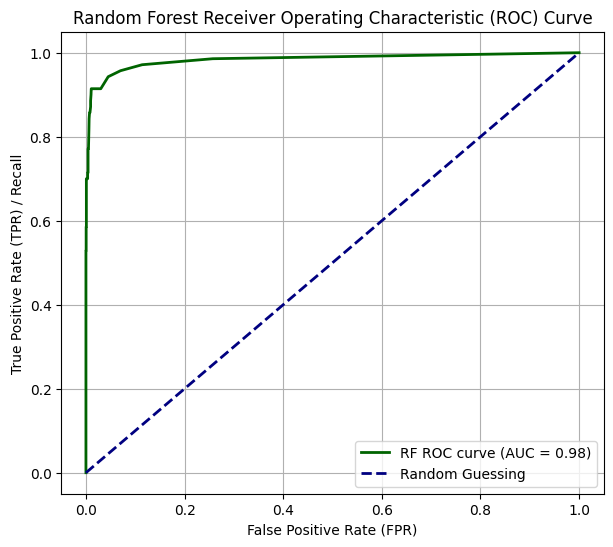


--- Random Forest Model Evaluation Complete! ---


In [20]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assumed: X_train, X_test, y_train, y_test are available from Sub-Step 5.1.

print("\n--- Sub-Step 5.5: Training and Evaluating a Random Forest Classifier ---")

# --- 1. Initialize the Random Forest Model ---
# Key parameters for Random Forest:
# n_estimators: The number of trees in the forest. More trees generally improve performance but increase computation time.
# random_state: For reproducibility.
# class_weight: Crucial for imbalanced datasets, similar to Logistic Regression.
# max_depth: Limits the depth of each tree, can help prevent overfitting (optional to set initially).
# min_samples_leaf: Minimum number of samples required to be at a leaf node (optional).
rf_model = RandomForestClassifier(
    n_estimators=100,  # A good starting point, can be tuned
    random_state=42,
    class_weight='balanced', # Crucial for handling imbalanced data
    oob_score=True # Computes out-of-bag score, a robust estimate of generalization error
)

print("Random Forest Classifier initialized with class_weight='balanced'.")

# --- 2. Train the Random Forest Model ---
print("Training the Random Forest model...")
rf_model.fit(X_train, y_train)
print(f"Out-of-Bag Score: {rf_model.oob_score_:.4f}") # OOB score as a quick estimate of performance

print("\n--- Random Forest Model Training Complete! ---")

# --- 3. Make Predictions on the Test Set ---
# Predict class labels (0 or 1)
y_pred_rf = rf_model.predict(X_test)

# Predict probabilities of the positive class (churn = 1)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# --- 4. Evaluate Random Forest Model Performance ---
print("\n--- Random Forest Classification Report ---")
print(classification_report(y_test, y_pred_rf))

# Calculate ROC AUC Score
auc_score_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"Random Forest ROC AUC Score: {auc_score_rf:.4f}")

# --- 5. Visualize Random Forest Confusion Matrix ---
print("\n--- Visualizing Random Forest Confusion Matrix ---")
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No Churn', 'Predicted Churn'],
            yticklabels=['Actual No Churn', 'Actual Churn'])
plt.title('Random Forest Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# --- 6. Visualize Random Forest ROC Curve ---
print("\n--- Visualizing Random Forest ROC Curve ---")
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)

plt.figure(figsize=(7, 6))
plt.plot(fpr_rf, tpr_rf, color='darkgreen', lw=2, label=f'RF ROC curve (AUC = {auc_score_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('Random Forest Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\n--- Random Forest Model Evaluation Complete! ---")


--- Sub-Step 5.6: Feature Importance Analysis for Random Forest ---

Top 15 Most Important Features (Random Forest):
                                     Feature  Importance
25               days_since_last_transaction    0.247068
8           total_transactions_last_3_months    0.112282
7               total_spending_last_3_months    0.095754
10  unique_merchant_categories_last_3_months    0.077895
9       avg_transaction_amount_last_3_months    0.065834
26                   days_since_last_payment    0.048327
5                     total_spending_overall    0.045834
4                 total_transactions_overall    0.042979
27               days_since_last_interaction    0.024678
11                    total_payments_overall    0.023818
16          avg_payment_amount_last_3_months    0.023157
12                 total_amount_paid_overall    0.020442
24                       account_tenure_days    0.020410
15              total_payments_last_3_months    0.016330
18                total_int

/tmp/ipython-input-21-2826084099.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_rf_df.head(15), palette='magma')


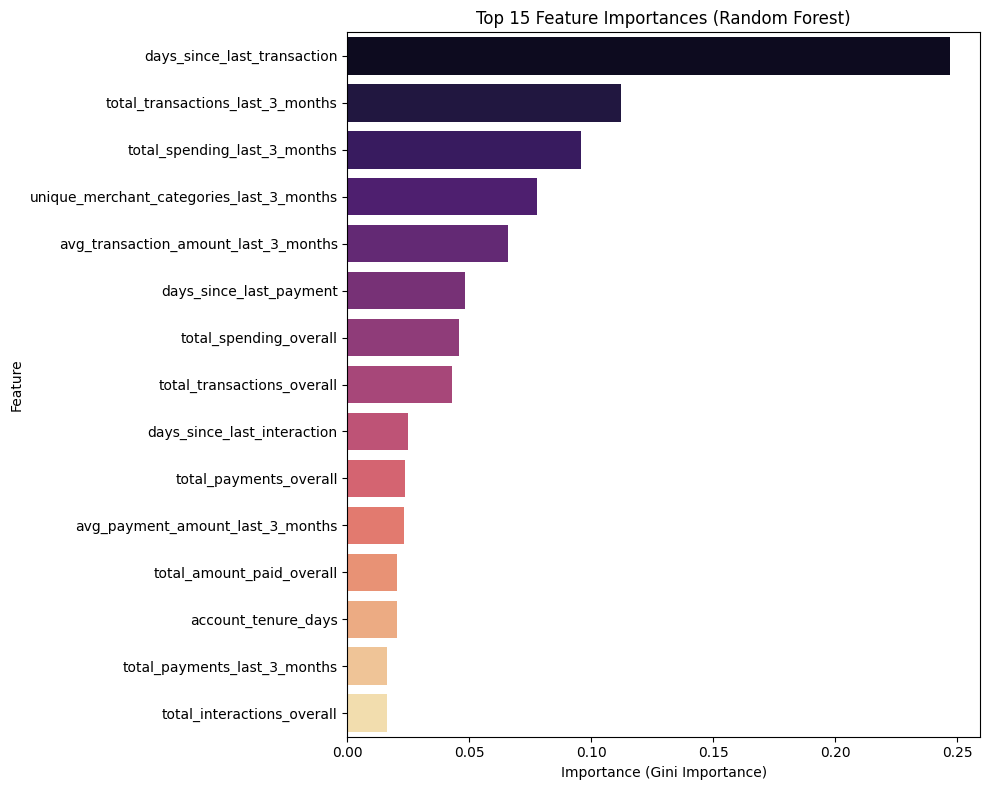


--- Random Forest Feature Importance Analysis Complete! ---


In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assumed: 'rf_model' (trained RandomForestClassifier) and 'X' (features DataFrame)
# --- are available from previous steps.

print("\n--- Sub-Step 5.6: Feature Importance Analysis for Random Forest ---")

# --- 1. Get Feature Names and Importances ---
# Random Forest models store feature importances in model.feature_importances_
feature_importances_rf = rf_model.feature_importances_

# Get the feature names from our X DataFrame
feature_names = X.columns

# Create a DataFrame to easily associate names with importances
feature_importance_rf_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_rf
})

# --- 2. Sort Features by Importance Value ---
feature_importance_rf_df = feature_importance_rf_df.sort_values(by='Importance', ascending=False)

print("\nTop 15 Most Important Features (Random Forest):")
print(feature_importance_rf_df.head(15))

# --- 3. Visualize Feature Importance ---
print("\n--- Visualizing Top 15 Random Forest Feature Importances ---")

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_rf_df.head(15), palette='magma')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance (Gini Importance)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("\n--- Random Forest Feature Importance Analysis Complete! ---")